# BranchPro: inference of R_t

The first part of the notebook includes a forward simulation of the incidence numbers for an example branching process model. The reproduction number profile is assumed to be a step function with only one jump.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- explicit calculation;
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd
import cmdstanpy
from cmdstanpy import CmdStanModel, cmdstan_path
import arviz as az
import nest_asyncio
nest_asyncio.apply()

num_timepoints = 30 # number of days for incidence data


/Users/ioaros/opt/anaconda3/envs/testbranchpro2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameterize example branching process model

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 3
serial_interval = disc_w
m = branchpro.BranchProModel(initial_r, serial_interval)
new_rs = [3, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

cases = m.simulate(parameters, times)
print(cases)

[ 100.    0.   81.  101.  123.  178.  249.  346.  502.  643.  953. 1284.
 1922. 2457. 3585. 4865. 1201. 1598. 1459. 1204. 1011.  806.  690.  578.
  492.  393.  329.  262.  243.  186.]


## Plot local incidence numbers

In [3]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Compute the posterior distribution using explicit method

In [4]:
# Posterior of R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

shape = []
rate = []
mean = []

i=0
for t in range(R_t_start,num_timepoints):
    shape.append( a + math.fsum(cases[(t-tau):(t+1)]) )
    sum_var = 0
    for k in range(t-tau,t+1):
        if k > len(serial_interval):
            vec1 = cases[(k-1):(k-len(serial_interval)-1):-1] # I_(k-1), ... , I_0
            vec2 = serial_interval[:k] # w_1, ... , w_k
        else:
            vec1 = cases[(k-1)::-1] # I_(k-1), ... , I_0
            vec2 = serial_interval[:k] # w_1, ... , w_k
        sum_var += math.fsum( np.multiply(vec1,vec2) )
    rate.append( b + sum_var )
    i += 1

# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

mean = np.divide(shape, rate)

post_dist = scipy.stats.gamma(shape,scale = 1/np.array(rate))
post_dist_interval = post_dist.interval(.95)


## Inference plot using explicit calculation results

In [5]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[3] + L2*[0.5]
})

interval = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': mean,
    'Lower bound CI': post_dist_interval[0],
    'Upper bound CI': post_dist_interval[1],
    'Central Probability': (L1+L2) * [0.95]
})

In [6]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using pre-computed posterior class method

In [7]:
# Same inference, but using the BranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': cases
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

## Inference plot using class method results

In [8]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using sampling class method

In [9]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': cases
    }
)

inference_new = branchpro.PoissonBranchProLogPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau=tau,
    alpha=a,
    beta=b)


/Users/ioaros/opt/anaconda3/envs/testbranchpro2/lib/python3.10/site-packages/pints/_mcmc/_nuts.py:257: RuntimeWarning:

overflow encountered in exp

/Users/ioaros/opt/anaconda3/envs/testbranchpro2/lib/python3.10/site-packages/pints/_mcmc/_nuts.py:158: RuntimeWarning:

overflow encountered in exp



Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     57     0.5      8       0.62     2       0.595    2        0:00.0
1     60     0.25     1                        0.5      2        0:00.0
2     63     0.25     1                                          0:00.0
3     66     0.25     1                        0.167    1        0:00.0
20    636    0.765091 7       0.742    14      0.761554 7        0:00.4
40    1416   0.737028 13      0.759295 13      0.747703 14       0:00.8
60    2184   0.766    12      0.757    13      0.763    12       0:01.3
80    2832   0.751    12      0.748    11      0.77     10       0:01.6
100   3633   0.761    8       0.753    13      0.744    8        0:02.1
120   4161   0.771    9       0.735    9       0.715    6        0:02.4
140   4689   0.713    7       0.75     9       0.759    10       0:02.7
160   5127   0.762    8       0.739    7       0.768847

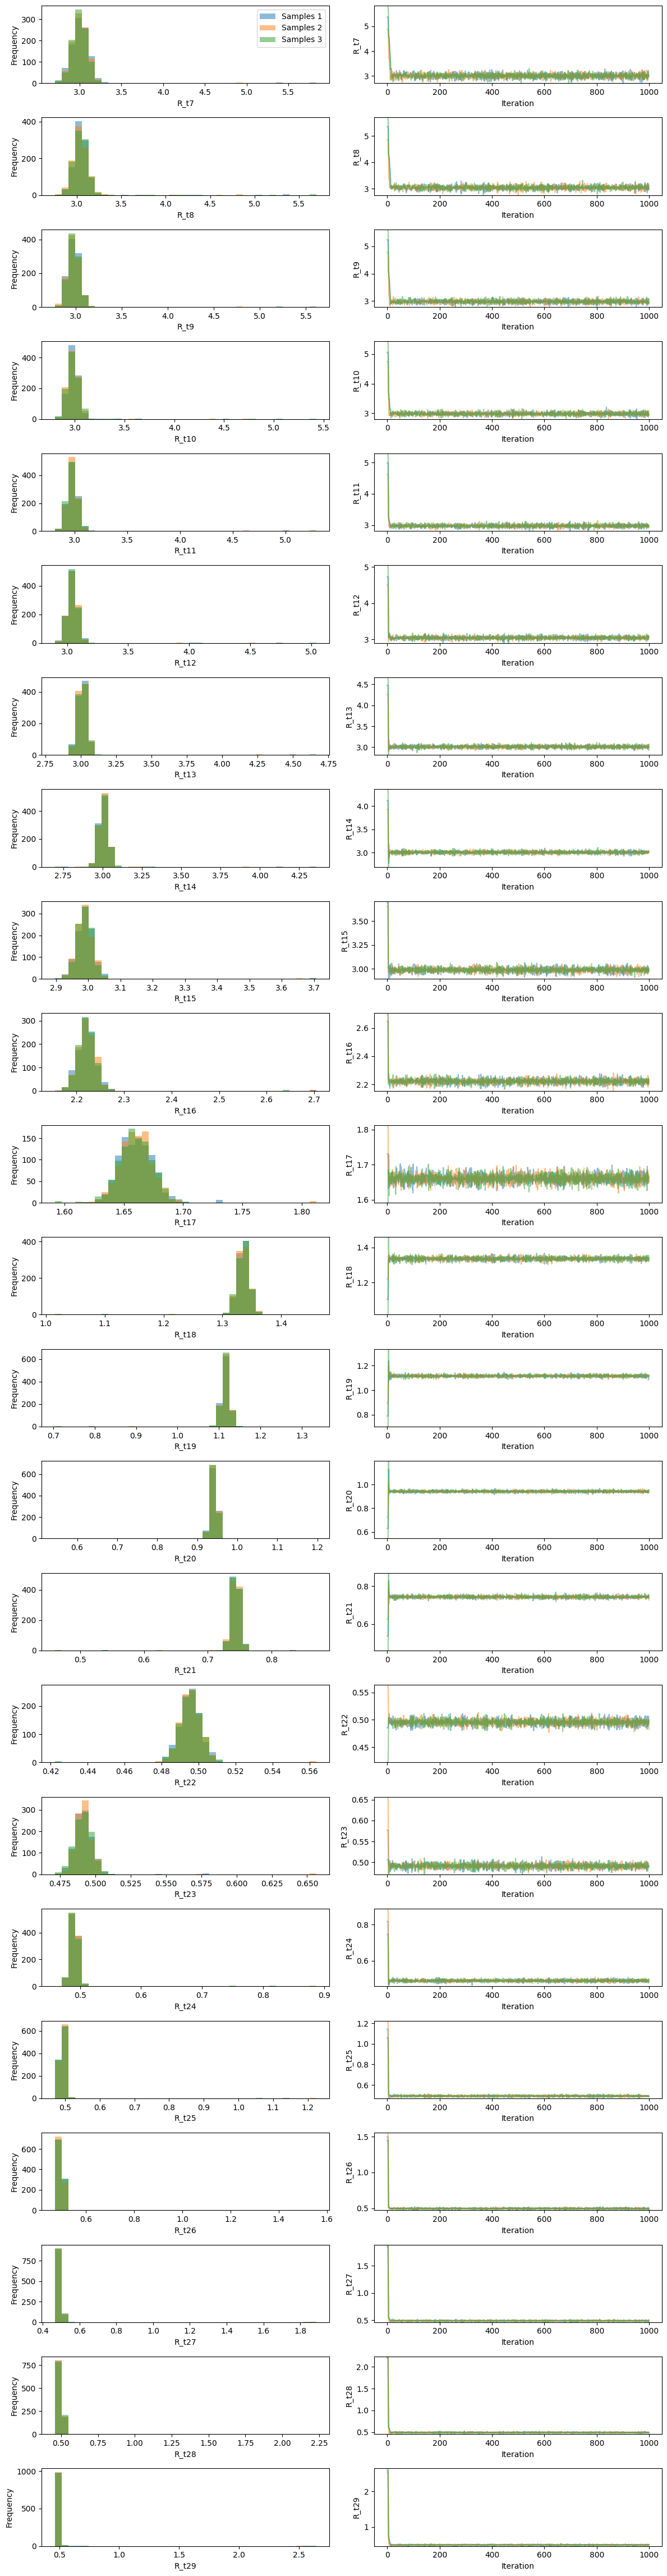

In [10]:
samples = inference_new.run_inference(num_iter=1000)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []
for _ in range(inference_new.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_ + R_t_start))

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 50))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [11]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



In [12]:
dLl = []
old_r_profile = ground_truth['R_t'].to_list()

total_time = inference_new.ll.cases_times.max() - inference_new.ll.cases_times.min() + 1
time_init_inf_r = inference_new.ll._tau + 1

for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
    new_r_profile = old_r_profile.copy()
    new_r_profile[_] = old_r_profile[_] + 10**(-5)
    dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

print(dLl)
print(inference_new.ll._compute_derivative_log_likelihood(old_r_profile))

[-0.0014289980754256246, 6.536906585097312, -5.50047552678734, -7.121061207726597, -11.652495595626531, 27.175163268111643, 9.015356772579253, 10.053490404970944, -20.931888138875365, 25209.42520059179, 23639.6786494879, 21381.158218719065, 18065.76553499326, 13992.048996442461, 7956.586433283518, -143.47993856063113, -258.6351096397266, -258.0314496299252, -151.80583141045645, -91.58595203189178, -130.30846312176436, -50.10010354453697, -45.48057913780212]
[-0.0008299684229200466, 6.53778590527736, -5.499284810576569, -7.119397684634805, -11.650186986506924, 27.178441586442887, 9.019862810652285, 10.05979650555446, -20.923158161082938, 25209.750536263757, 23640.016887794525, 21381.499955462, 18066.092910514642, 13992.34745302134, 7956.829309619143, -143.32056090367405, -258.4881903564037, -257.9066514558872, -151.7023517766429, -91.49997332812018, -130.2374646823955, -50.04036439224001, -45.43092004342088]


In [13]:
theta_hat = inference_new.run_optimisation()[0]
S_vector = np.multiply(np.reciprocal(np.array(shape)-1), np.square(theta_hat))
S = np.diag(S_vector)

# q_theta = scipy.stats.multivariate_normal(theta_hat, S)
q_theta1 = scipy.stats.norm(theta_hat, np.sqrt(S_vector))
interval2 = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': q_theta1.mean(),
    'Lower bound CI': q_theta1.interval(0.95)[0],
    'Upper bound CI': q_theta1.interval(0.95)[1],
    'Central Probability': (L1+L2) * [0.95]
})

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 13
Iter. Eval.  Best      Current   Time m:s
0     13     -80756.8  -80756.8    0:00.1
1     26     -78206.53 -78206.53   0:00.1
2     39     -52200.67 -52200.67   0:00.1
3     52     -52200.67 -63154.81   0:00.1
20    273    -40205.85 -43153.4    0:00.2
40    533    -32148.31 -32148.31   0:00.3
60    793    -30993.18 -30993.18   0:00.4
80    1053   -30506.13 -30515.03   0:00.5
100   1313   -30365.16 -30365.16   0:00.6
120   1573   -30336.23 -30336.23   0:00.7
140   1833   -30331.6  -30331.76   0:00.9
160   2093   -30330.05 -30330.05   0:01.0
180   2353   -30329.72 -30329.72   0:01.1
200   2613   -30329.65 -30329.65   0:01.2
220   2873   -30329.64 -30329.64   0:01.3
240   3133   -30329.63 -30329.63   0:01.4
259   3367   -30329.63 -30329.63   0:01.5
Halting: No significant change for 100 iterations.
[3.00115231 3.03843728 2.97762385 2.97915567 2.97545758 3.042144

In [14]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval2)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using STAN

In [16]:
poisson_model = CmdStanModel(stan_file=os.path.join(
        '../branchpro/stan_models/poisson.stan'))

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1]}

13:28:44 - cmdstanpy - INFO - compiling stan file /var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/tmp62ez_8n3/tmprlzjm_pz.stan to exe file /Users/ioaros/Desktop/Software Project/branchpro/branchpro/stan_models/poisson
13:28:57 - cmdstanpy - INFO - compiled model executable: /Users/ioaros/Desktop/Software Project/branchpro/branchpro/stan_models/poisson
/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_7646/4102607491.py:7: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [19]:
fit = poisson_model.sample(data=poisson_data, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

13:45:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status
chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:02 Iterat


13:45:32 - cmdstanpy - INFO - CmdStan done processing.
13:45:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'poisson.stan', line 42, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'poisson.stan', line 42, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'poisson.stan', line 42, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'poisson.stan', line 42, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'poisson.stan', line 42, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'poisson.stan', line 42, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'poisson.stan', line 42, col

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],3.002,0.089,2.839,3.172,0.001,0.001,6626.0,2117.0,1.0
R[1],3.037,0.077,2.888,3.176,0.001,0.001,6613.0,2037.0,1.0
R[2],2.976,0.067,2.854,3.100,0.001,0.001,7764.0,2349.0,1.0
R[3],2.978,0.055,2.874,3.076,0.001,0.000,8014.0,2229.0,1.0
R[4],2.975,0.045,2.889,3.057,0.001,0.000,6452.0,2180.0,1.0
R[5],3.042,0.040,2.973,3.123,0.000,0.000,7946.0,1804.0,1.0
R[6],3.012,0.033,2.947,3.073,0.000,0.000,7919.0,1843.0,1.0
R[7],3.008,0.029,2.954,3.060,0.000,0.000,6789.0,1815.0,1.0
R[8],2.988,0.024,2.941,3.029,0.000,0.000,6745.0,1897.0,1.0
R[9],2.221,0.017,2.189,2.251,0.000,0.000,7618.0,2289.0,1.0


array([[<Axes: title={'center': 'R\n0'}>,
        <Axes: title={'center': 'R\n0'}>],
       [<Axes: title={'center': 'R\n1'}>,
        <Axes: title={'center': 'R\n1'}>],
       [<Axes: title={'center': 'R\n2'}>,
        <Axes: title={'center': 'R\n2'}>],
       [<Axes: title={'center': 'R\n3'}>,
        <Axes: title={'center': 'R\n3'}>],
       [<Axes: title={'center': 'R\n4'}>,
        <Axes: title={'center': 'R\n4'}>],
       [<Axes: title={'center': 'R\n5'}>,
        <Axes: title={'center': 'R\n5'}>],
       [<Axes: title={'center': 'R\n6'}>,
        <Axes: title={'center': 'R\n6'}>],
       [<Axes: title={'center': 'R\n7'}>,
        <Axes: title={'center': 'R\n7'}>],
       [<Axes: title={'center': 'R\n8'}>,
        <Axes: title={'center': 'R\n8'}>],
       [<Axes: title={'center': 'R\n9'}>,
        <Axes: title={'center': 'R\n9'}>],
       [<Axes: title={'center': 'R\n10'}>,
        <Axes: title={'center': 'R\n10'}>],
       [<Axes: title={'center': 'R\n11'}>,
        <Axes: title

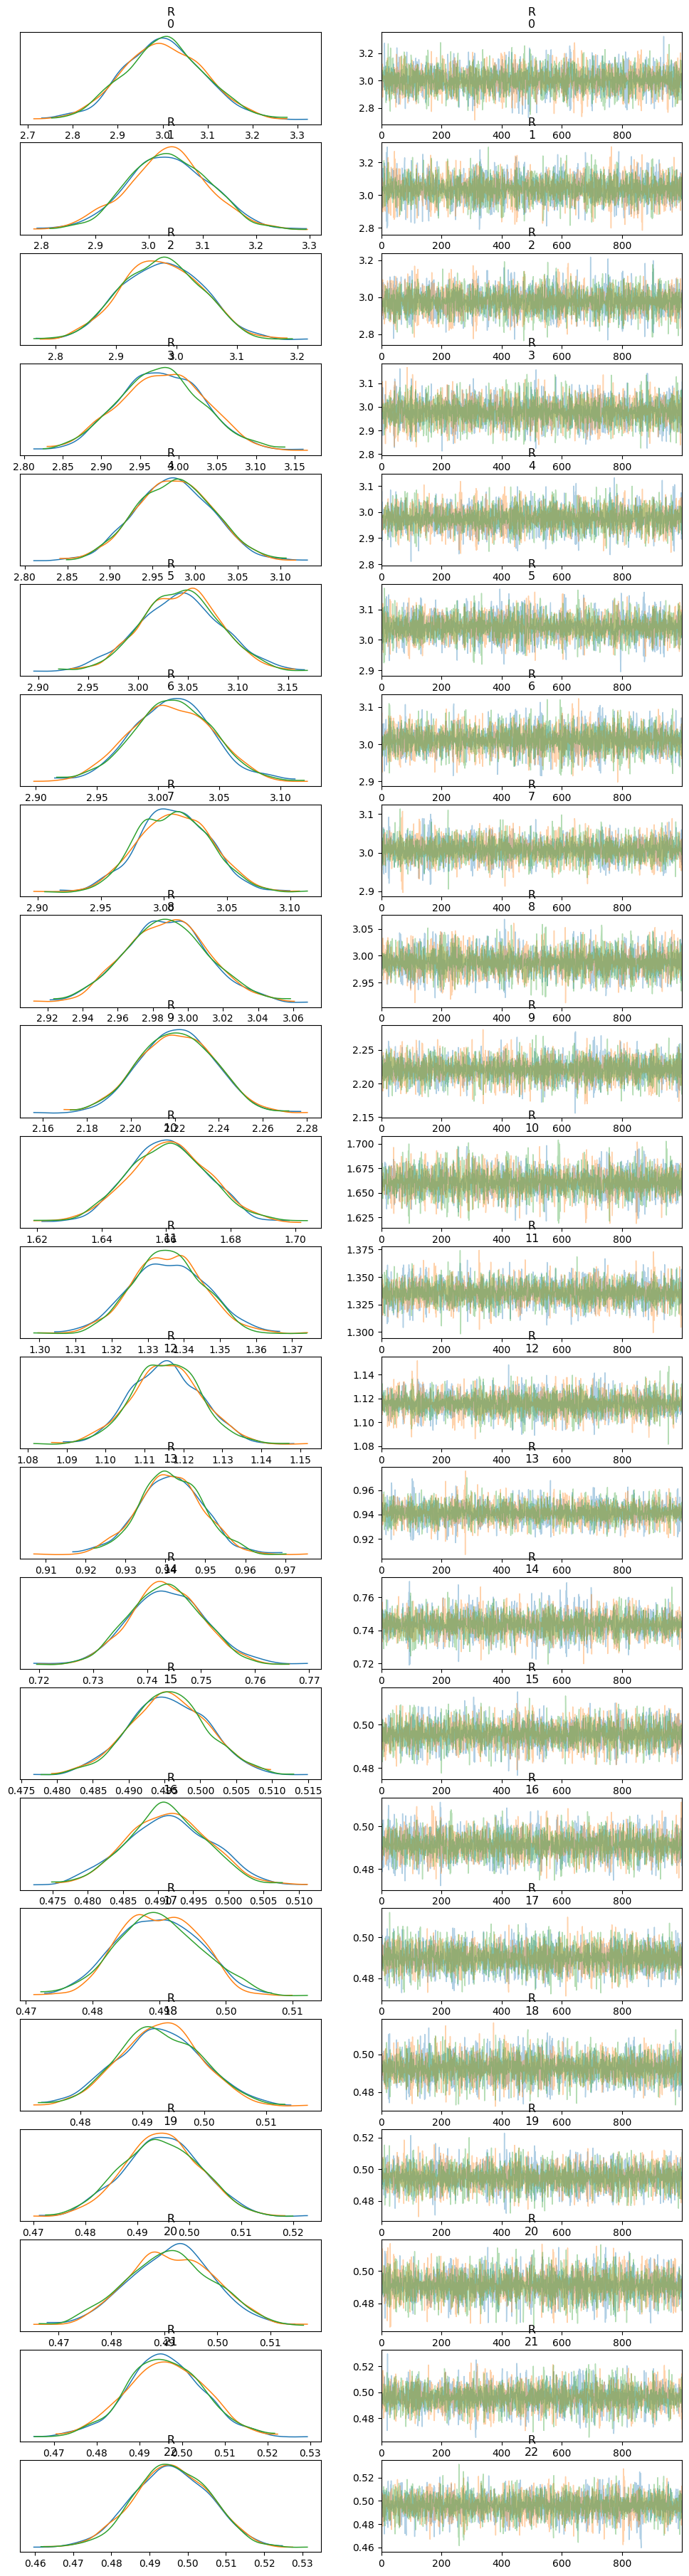

In [20]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [27]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [28]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

